In [1]:
import os
import numpy as np
import pywt
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.optimizers import SGD

In [2]:
# Đường dẫn đến tệp hình ảnh gốc
path_to_data = "data"

# Đường dẫn đến hình ảnh khuôn mặt đã được cắt từ hình ảnh gốc
path_to_cr_data = "crop"

In [3]:
# Tạo một danh sách để lưu trữ đường dẫn các thư mục
img_dirs = []

# Duyệt qua các tệp và thư mục trong đường dẫn đã cho
for entry in os.scandir(path_to_cr_data):
    # Kiểm tra nếu là thư mục
    if entry.is_dir():
        # Thêm đường dẫn của thư mục vào danh sách
        img_dirs.append(entry.path)

# In danh sách các đường dẫn thư mục
print(img_dirs)

['crop\\Anushka_Sharma', 'crop\\Barack_Obama', 'crop\\Bill_Gates', 'crop\\Dalai_Lama', 'crop\\Indira_Nooyi', 'crop\\Melinda_Gates', 'crop\\Narendra_Modi', 'crop\\Sundar_Pichai', 'crop\\Vikas_Khanna', 'crop\\Virat_Kohli']


In [4]:
# Khởi tạo một từ điển để lưu trữ danh sách tệp ảnh cho từng người nổi tiếng
celebrity_file_names_dict = {}

# Lặp qua danh sách các thư mục chứa dữ liệu hình ảnh của các người nổi tiếng
for img_dir in img_dirs:
    # Trích xuất tên của người nổi tiếng từ đường dẫn thư mục
    celebrity_name = os.path.basename(img_dir)
    
    # Khởi tạo danh sách để lưu trữ đường dẫn của các tệp ảnh
    file_list = []
    
    # Lặp qua các tệp và thư mục trong thư mục của người nổi tiếng
    for entry in os.scandir(img_dir):
        # Thêm đường dẫn của tệp vào danh sách
        file_list.append(entry.path)
    
    # Lưu danh sách tệp ảnh của người nổi tiếng vào từ điển
    celebrity_file_names_dict[celebrity_name] = file_list

In [5]:
# Khởi tạo một từ điển để ánh xạ tên người nổi tiếng sang các giá trị số nguyên
class_dict = {}

# Khởi tạo biến đếm
count = 0

# Lặp qua các tên người nổi tiếng trong từ điển danh sách tệp ảnh (celebrity_file_names_dict)
for celebrity_name in celebrity_file_names_dict.keys():
    # Gán giá trị số nguyên cho tên người nổi tiếng và lưu vào từ điển
    class_dict[celebrity_name] = count
    
    # Tăng giá trị đếm
    count = count + 1

print(class_dict)

{'Anushka_Sharma': 0, 'Barack_Obama': 1, 'Bill_Gates': 2, 'Dalai_Lama': 3, 'Indira_Nooyi': 4, 'Melinda_Gates': 5, 'Narendra_Modi': 6, 'Sundar_Pichai': 7, 'Vikas_Khanna': 8, 'Virat_Kohli': 9}


In [6]:
# Tạo một từ điển ngược (inverted dictionary) để ánh xạ các giá trị số nguyên thành tên người nổi tiếng
inv_dict = {v: k for k, v in class_dict.items()}

print(inv_dict)

{0: 'Anushka_Sharma', 1: 'Barack_Obama', 2: 'Bill_Gates', 3: 'Dalai_Lama', 4: 'Indira_Nooyi', 5: 'Melinda_Gates', 6: 'Narendra_Modi', 7: 'Sundar_Pichai', 8: 'Vikas_Khanna', 9: 'Virat_Kohli'}


In [7]:
# Khởi tạo danh sách X và y để lưu trữ dữ liệu đào tạo và nhãn tương ứng
X, y = [], []

# Lặp qua từng người nổi tiếng và danh sách tệp ảnh của họ
for celebrity_name, training_files in celebrity_file_names_dict.items():
    # Lặp qua từng tệp ảnh đào tạo của người nổi tiếng
    for training_image in training_files:
        # Đọc hình ảnh từ tệp
        img = cv2.imread(training_image)
        
        # Kiểm tra xem hình ảnh đã được đọc thành công chưa
        if img is not None:
            # Định dạng lại kích thước hình ảnh thành 32x32
            scalled_raw_img = cv2.resize(img, (32, 32))
            
            # Thêm dữ liệu hình ảnh và nhãn tương ứng vào danh sách X và y
            X.append(scalled_raw_img)
            y.append(class_dict[celebrity_name])

In [8]:
# Biến đổi danh sách hình ảnh X thành một mảng NumPy 4D
X = np.array(X).reshape(len(X), 32, 32, 3).astype(float)

# Biến đổi danh sách nhãn y thành một mảng NumPy 1D
y = np.array(y).reshape(-1).astype(float)

# Kiểm tra kích thước của mảng X và mảng y
print("Kích thước mảng X:", X.shape)
print("Kích thước mảng y:", y.shape)

Kích thước mảng X: (2799, 32, 32, 3)
Kích thước mảng y: (2799,)


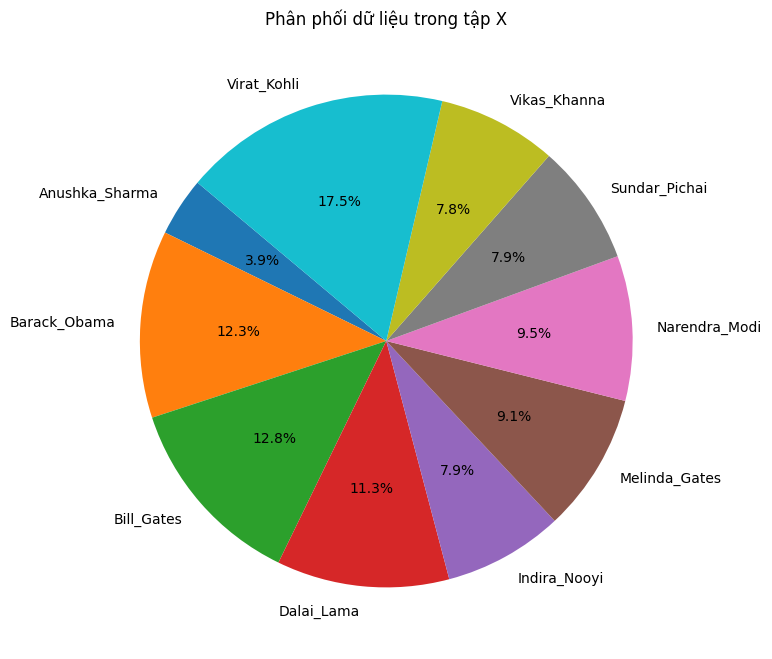

In [9]:
# Tính số lượng mẫu cho mỗi lớp
class_counts = [len(X[y == i]) for i in range(len(class_dict))]

# Tên các lớp (người nổi tiếng)
class_names = [inv_dict[i] for i in range(len(inv_dict))]

# Vẽ biểu đồ tròn
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_names, autopct='%1.1f%%', startangle=140)
plt.title('Phân phối dữ liệu trong tập X')
plt.show()

In [10]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra sử dụng train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [11]:
# Chuẩn hóa giá trị pixel của các hình ảnh bằng cách chia cho 255.0 để đưa về khoảng [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0

In [12]:
# Tạo một mô hình Sequential
cnn = models.Sequential([
    # Layer Convolutional với 32 bộ lọc kích thước (3, 3) và hàm kích hoạt ReLU
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)),
    # Layer MaxPooling để giảm kích thước của feature map
    layers.MaxPooling2D((2, 2)),
    
    # Layer Convolutional với 64 bộ lọc kích thước (3, 3) và hàm kích hoạt ReLU
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    # Layer MaxPooling để giảm kích thước của feature map
    layers.MaxPooling2D((2, 2)),
    
    # Layer Flatten để chuyển đổi feature map thành vector
    layers.Flatten(),
    # Layer Fully Connected với 64 đơn vị và hàm kích hoạt ReLU
    layers.Dense(64, activation='relu'),
    # Layer Fully Connected cuối cùng với 10 đơn vị và hàm kích hoạt softmax (đối với bài toán phân loại 10 lớp)
    layers.Dense(10, activation='softmax')
])

# Biên dịch mô hình bằng cách chỉ định optimizer, loss function và metrics
cnn.compile(optimizer='SGD',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Đào tạo mô hình trên dữ liệu huấn luyện
cnn.fit(X_train, y_train, epochs=40)

Epoch 1/40
70/70 [==============================] - 2s 14ms/step - loss: 2.2615 - accuracy: 0.1630
Epoch 2/40
70/70 [==============================] - 1s 14ms/step - loss: 2.2250 - accuracy: 0.1733
Epoch 3/40
70/70 [==============================] - 1s 14ms/step - loss: 2.1994 - accuracy: 0.1831
Epoch 4/40
70/70 [==============================] - 1s 14ms/step - loss: 2.1576 - accuracy: 0.2202
Epoch 5/40
70/70 [==============================] - 1s 14ms/step - loss: 2.0939 - accuracy: 0.2805
Epoch 6/40
70/70 [==============================] - 1s 14ms/step - loss: 2.0148 - accuracy: 0.3247
Epoch 7/40
70/70 [==============================] - 1s 15ms/step - loss: 1.8943 - accuracy: 0.3694
Epoch 8/40
70/70 [==============================] - 1s 15ms/step - loss: 1.7924 - accuracy: 0.3881
Epoch 9/40
70/70 [==============================] - 1s 14ms/step - loss: 1.6817 - accuracy: 0.4431
Epoch 10/40
70/70 [==============================] - 1s 14ms/step - loss: 1.5527 - accuracy: 0.4833
Epoch 11/

In [13]:
# Dự đoán nhãn cho tập kiểm tra
y_pred = cnn.predict(X_test)

18/18 [==============================] - 0s 5ms/step


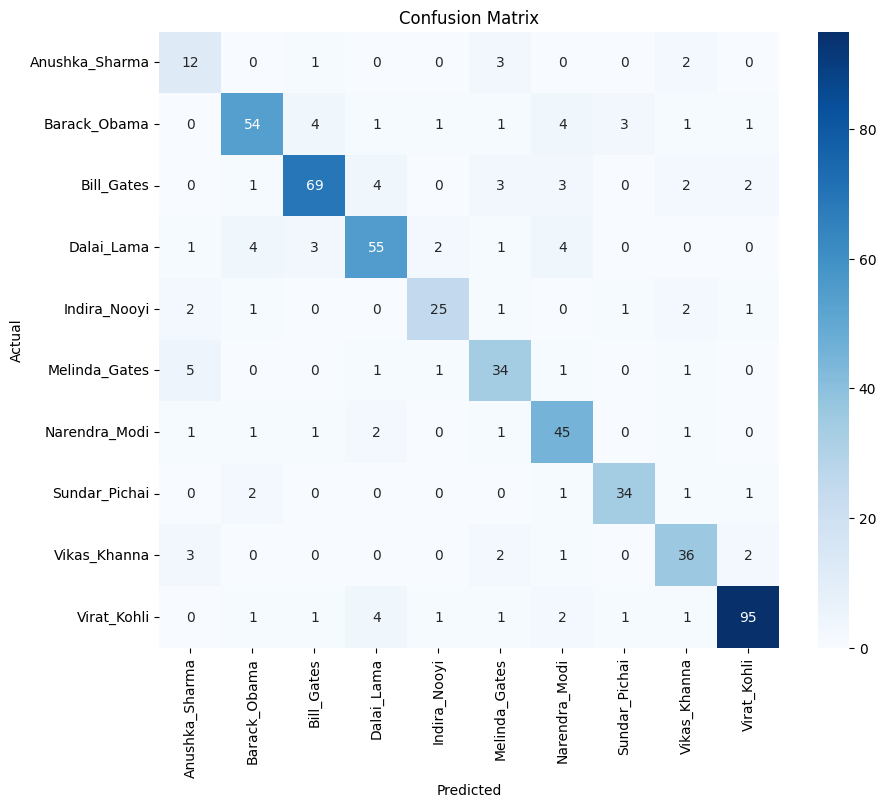

In [14]:
# Chuyển đổi dự đoán thành danh sách các lớp được dự đoán (các lớp có xác suất cao nhất)
y_pred_classes = [np.argmax(element) for element in y_pred]

# Tính toán ma trận nhầm lẫn
confusion_mtx = confusion_matrix(y_test, y_pred_classes)

# Lấy danh sách tên các lớp (người nổi tiếng) từ từ điển ngược inv_dict
class_names = [inv_dict[i] for i in range(len(inv_dict))]

# Vẽ biểu đồ heatmap cho confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [15]:
# Tính và in ra báo cáo phân loại
classification_rep = classification_report(y_test, y_pred_classes, target_names=class_names)
print("Classification Report:\n", classification_rep)

Classification Report:
                 precision    recall  f1-score   support

Anushka_Sharma       0.50      0.67      0.57        18
  Barack_Obama       0.84      0.77      0.81        70
    Bill_Gates       0.87      0.82      0.85        84
    Dalai_Lama       0.82      0.79      0.80        70
  Indira_Nooyi       0.83      0.76      0.79        33
 Melinda_Gates       0.72      0.79      0.76        43
 Narendra_Modi       0.74      0.87      0.80        52
 Sundar_Pichai       0.87      0.87      0.87        39
  Vikas_Khanna       0.77      0.82      0.79        44
   Virat_Kohli       0.93      0.89      0.91       107

      accuracy                           0.82       560
     macro avg       0.79      0.80      0.79       560
  weighted avg       0.83      0.82      0.82       560



In [16]:
# Lưu mô hình vào một tệp tin
cnn.save("my_model.h5")

c:\Users\Huan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 61ms/step


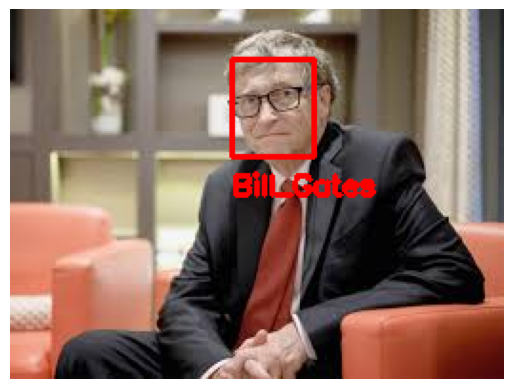

In [17]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from mtcnn.mtcnn import MTCNN
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Tải lại mô hình từ tệp my_model.h5
loaded_model = load_model("my_model.h5")

# Tạo một đối tượng MTCNN
mtcnn = MTCNN()

# Đường dẫn đến hình ảnh chưa được cắt khuôn mặt
image_path = 'data/Bill_Gates/bigates_024.jpg'

# Đọc hình ảnh
img = cv2.imread(image_path)

# Sử dụng MTCNN để cắt khuôn mặt từ hình ảnh
faces = mtcnn.detect_faces(img)

# Kiểm tra xem có khuôn mặt được phát hiện trong hình ảnh hay không
if faces:
    # Lấy tọa độ của khuôn mặt đầu tiên
    x, y, w, h = faces[0]['box']
    
    # Cắt khuôn mặt từ hình ảnh gốc
    face_img = img[y:y+h, x:x+w]
    
    # Định dạng lại kích thước của khuôn mặt thành 32x32
    scalled_face_img = cv2.resize(face_img, (32, 32))
    
    # Thực hiện dự đoán bằng mô hình
    img_for_prediction = scalled_face_img.reshape(1, 32, 32, 3).astype(float) / 255.0
    
    prediction = loaded_model.predict(img_for_prediction)
    predicted_class = np.argmax(prediction)
    
    # Chuyển đổi lớp dự đoán thành tên người nổi tiếng sử dụng từ điển inv_dict
    predicted_celebrity = inv_dict[predicted_class]
    
    # Trích xuất tên của người nổi tiếng từ tên đường dẫn cuối cùng bằng cách sử dụng os.path.basename
    celebrity_name = os.path.basename(predicted_celebrity)
    
    # Vẽ khung chứa khuôn mặt lên hình ảnh gốc màu đỏ
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)  # Màu đỏ: (0, 0, 255)
    
    # Đặt màu chữ thành đỏ
    text_color = (0, 0, 255)
    
    # Thêm tên của người nổi tiếng dưới khung chứa khuôn mặt
    cv2.putText(img, celebrity_name, (x, y + h + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 2)
    
    # Chuyển đổi mảng NumPy của OpenCV thành mảng NumPy của Matplotlib để hiển thị trong Jupyter Notebook
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Hiển thị hình ảnh và kết quả
    plt.imshow(img_rgb)
    plt.axis('off')  # Ẩn trục
    plt.show()
    
else:
    print('Không tìm thấy khuôn mặt trong hình ảnh.')